# Vehicle Speed Estimation from Video

[Related article on medium](https://medium.com/@selfouly/vehicle-speed-estimation-from-video-using-deep-learning-18b41babda4c)

[Dataset on github](https://github.com/commaai/speedchallenge)



This task contains two main steps
1. Loading the video and converting it to its consecutive frames and then calculating displacements using optical flow pre-trained models.
2. Creating a CNN to predict speed from displacements.

In [ ]:
import sys
import cv2
import torch
from matplotlib import pyplot as plt
import torch
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch import nn, optim
import numpy as np
import os
import argparse
sys.path.append('/content/drive/MyDrive/RAFT/core')
from raft import RAFT
from utils import *
from utils.utils import InputPadder
from utils import flow_viz
from PIL import Image

## First Step) Optical Flow Estimation
Here we firstly load the video and convert it to its frames and save them.

This process is done for both train and test separately.

Finally, the results are saved in **train_frames** and **test_frames**.

There are 20400 frames for train and 10798 frames for test.

In [ ]:
video_path = '/content/drive/MyDrive/Q3/train.mp4'

In [ ]:
frames_dir = '/content/drive/MyDrive/Q3/train_frames'

In [ ]:
os.makedirs(frames_dir, exist_ok=True)

In [ ]:
video = cv2.VideoCapture(video_path)

In [ ]:
frame_count = 0
frames = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    frame_filename = os.path.join(frames_dir, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_filename, frame)
    frames.append(frame_filename)
    frame_count += 1
video.release()

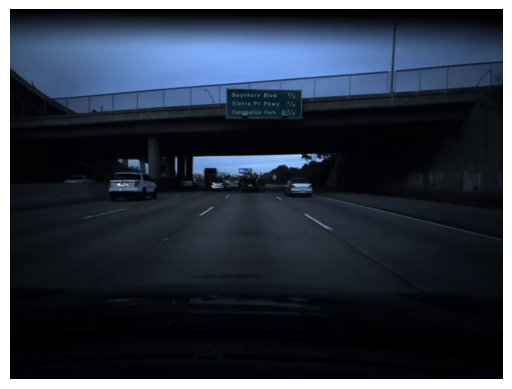

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(frames[0]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


---

Now that frames are ready, it is time to estimate flow using optical flow estimation models.

The approach we have chosen is **RAFT: Recurrent All-Pairs Field Transforms for Optical Flow**.

### Why RAFT?

There are copious reasons associated with this choice such as:
* RAFT is a pre-trained deep learning based model
* It is an end-to-end network
* It has a high accuracy with relatively high speed for estimation
* It is a combination of CNNs and RNNs
* It is robust and invariant to brightness change, noise, large displacements and other challenges


There are two reasons, however, that stand out among these which have led to this choice:
1. RAFT was trained on KITTI dataset which includes scenes captured from a car driving through urban environments, making it suitable for our task.
2. It is robust to noise and brightness change which was mentioned before.



[Paper link here](https://arxiv.org/pdf/2003.12039)



[Official github implementation](https://github.com/princeton-vl/RAFT?tab=readme-ov-file)

### How To Use RAFT
1. Clone the github repo
2. Install the requirements
3. Download the pre-trained model
4. Load the model and frames and predict flow
5. Save the flow in HSV

In [ ]:
flows_dir = '/content/drive/MyDrive/Q3/train_flows'

In [ ]:
os.makedirs(flows_dir, exist_ok=True)

In [ ]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None]

def save_flow(flow, output_file):
    flow_img = flow_viz.flow_to_image(flow)
    cv2.imwrite(output_file, flow_img)

Loading the model and its parameters

In [ ]:
args = argparse.Namespace()
args.model = '/content/drive/MyDrive/RAFT/core/raft-things.pth'
args.small = False
args.mixed_precision = False
args.alternate_corr = False

# Load RAFT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))
model = model.module
model.to(device)
model.eval()

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

Creating and saving flow

In [ ]:
for i in range(len(frames) - 1):
    image1 = load_image(frames[i]).to(device)
    image2 = load_image(frames[i+1]).to(device)
    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)
    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
    flow = flow_up[0].permute(1, 2, 0).cpu().numpy()
    flow_filename = os.path.join(flows_dir, f'flow_{i:04d}.png')
    save_flow(flow, flow_filename)

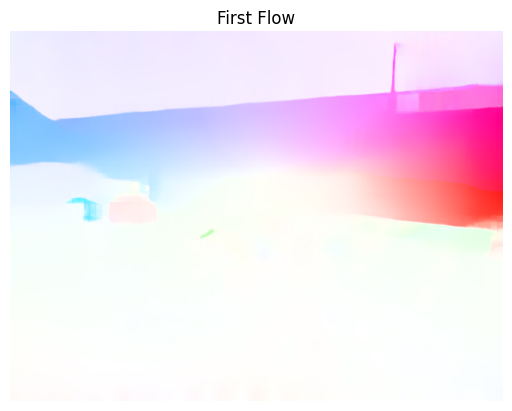

In [ ]:
plt.imshow(cv2.imread('/content/drive/MyDrive/Q3/train_flows/flow_0000.png'))
plt.axis('off')
plt.title('First Flow')
plt.show()

Now we have both **train_flows** and **test_flows**.

And we have labels in **train_speeds.txt** and **test_speeds.txt**.

Before creating the model, due to the huge load of data we need to preprocess it and save it as **.npy** file.

In [ ]:
def preprocess_and_save(image_folder, speed_file, save_folder):
    images = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    speeds = [float(speed) for speed in open(speed_file).read().splitlines()]

    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    os.makedirs(save_folder, exist_ok=True)
    for idx, img_path in enumerate(images):
        image = Image.open(img_path)
        image = preprocess(image).numpy()
        speed = speeds[idx]

        np.save(os.path.join(save_folder, f'image_{idx}.npy'), image)
        np.save(os.path.join(save_folder, f'speed_{idx}.npy'), speed)

In [ ]:
preprocess_and_save('/content/drive/MyDrive/Q3/train_flows', '/content/drive/MyDrive/Q3/train_speeds.txt', '/content/drive/MyDrive/Q3/train_preprocessed')
preprocess_and_save('/content/drive/MyDrive/Q3/test_flows', '/content/drive/MyDrive/Q3/test_speeds.txt', '/content/drive/MyDrive/Q3/test_preprocessed')

---
## Second Step) Speed Estimation with CNNs

Here we load the dataset and try some famous pre-trained models.

Loading and preprocessing data

In [ ]:
class PreprocessedSpeedDataset(Dataset):
    def __init__(self, folder):
        self.image_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.startswith('image')]
        self.speed_files = [f.replace('image', 'speed') for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = np.load(self.image_files[idx])
        speed = np.load(self.speed_files[idx])
        image = torch.tensor(image, dtype=torch.float32)
        speed = torch.tensor(speed, dtype=torch.float32)
        return image, speed

In [ ]:
train_dataset = PreprocessedSpeedDataset('train_preprocessed')
test_dataset = PreprocessedSpeedDataset('test_preprocessed')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4, pin_memory=True)

### 1. ResNet18

In [ ]:
class ResNet18Model(nn.Module):
    def __init__(self):
        super(ResNet18Model, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        self.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18Model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training loop

In [ ]:
num_epochs = 12
for epoch in range(num_epochs):
    model.train()
    for images, speeds in train_loader:
        images = images.to(device)
        speeds = speeds.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), speeds)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/12, Loss: 4.187345504760742
Epoch 2/12, Loss: 30.26090431213379
Epoch 3/12, Loss: 3.1012802124023438
Epoch 4/12, Loss: 7.379020690917969
Epoch 5/12, Loss: 1.9505150318145752
Epoch 6/12, Loss: 2.743001699447632
Epoch 7/12, Loss: 0.851967990398407
Epoch 8/12, Loss: 1.2023284435272217
Epoch 9/12, Loss: 0.6890575885772705
Epoch 10/12, Loss: 2.3645408153533936
Epoch 11/12, Loss: 0.4440564215183258
Epoch 12/12, Loss: 0.4605022370815277


Evaluation

In [ ]:
model.eval()
total_loss = 0
with torch.no_grad():
    for images, speeds in test_loader:
        images = images.to(device)
        speeds = speeds.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), speeds)
        total_loss += loss.item()
mean_loss = total_loss / len(test_loader)
print(f'Mean Test Loss: {mean_loss}')

### 2. EfficientNet

In [ ]:
class EfficientNetModel(nn.Module):
    def __init__(self, model_name='efficientnet-b0', pretrained=True):
        super(EfficientNetModel, self).__init__()
        self.base_model = EfficientNet.from_pretrained(model_name) if pretrained else EfficientNet.from_name(model_name)
        num_features = self.base_model._fc.in_features
        self.base_model._fc = nn.Identity()
        self.fc = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 282MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, speeds in train_loader:
        images = images.to(device)
        speeds = speeds.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), speeds)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/10, Loss: 24.408597946166992
Epoch 2/10, Loss: 4.497477054595947
Epoch 3/10, Loss: 8.270035743713379
Epoch 4/10, Loss: 7.115273952484131
Epoch 5/10, Loss: 2.0092244148254395
Epoch 6/10, Loss: 4.600245475769043
Epoch 7/10, Loss: 12.462136268615723
Epoch 8/10, Loss: 0.388039767742157
Epoch 9/10, Loss: 0.5554003119468689
Epoch 10/10, Loss: 4.119789123535156


In [ ]:
model.eval()
total_loss = 0
with torch.no_grad():
    for images, speeds in test_loader:
        images = images.to(device)
        speeds = speeds.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), speeds)
        total_loss += loss.item()
mean_loss = total_loss / len(test_loader)
print(f'Mean Test Loss: {mean_loss}')